# Learning Parity problem with quantum computer implementation

### TODO:
- obtain the error of every type of gates in the quantum computer (using `run_mode='fake'`). Please implement it in function `print_job_stats`

### 1. Connecting to ibm_clound device, basic setups

- Please use `pip install qiskit_ibm_runtime` to download dependencies.
- The `QiskitRuntimeService.save_account()` function only need to be run once. Please use your own token generated from the [IBM Quantum platform](https://quantum.cloud.ibm.com/). The tutorial document is at [here](https://quantum.cloud.ibm.com/docs/en/tutorials/hello-world), which is not required since the code has already been finished.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import generate_preset_pass_manager

# === Initializing ibm quantum computer resource === (Please comment these lines after the first run)
QiskitRuntimeService.save_account(
channel="ibm_cloud",
token="[Your token]", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
overwrite = True,
)

# Run every time you need the service (Do not need to be run everytime, since we are using jupyternotebook)
service = QiskitRuntimeService()

In [16]:
# === Testing of valid backends ===
backends = service.backends()
instances = service.instances()
print("Your instance:", instances)
print("Number of valie backends:", len(backends))
print("Valid backends:", service.backends())

Your instance: [{'crn': 'crn:v1:bluemix:public:quantum-computing:us-east:a/419f242236664107b8dcbd96c42e7f38:97c87797-6294-4e04-8f88-138274e892e7::', 'plan': 'open', 'name': 'open-instance', 'tags': [], 'pricing_type': 'free'}]
Number of valie backends: 3
Valid backends: [<IBMBackend('ibm_fez')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_torino')>]


### 2. The main code
- Recommand using `run_mode='fake'` to test the correctness before using `run_mode='quantum'`.
- Note that fake_provider is only capable with small $n$, so please lower the number $n$ before running. (I spent 1m24s for `n=6`, this is acceptable).
- The quantum computer takes at least 2m at every task, so maybe running several large tasks are more valuable than a lot of small tasks (should be done by `run_mode='fake'`).

Qubit number (n): 1
Correct answer (s): [0]
registers of circ: [ClassicalRegister(1, 'c')]
(0, [0])
Merged data:  {0: 567, 4: 433}
Job ID: 65a07616-2a07-48e9-ba27-9a92fc86aef9
Circuit Depth: 4804
Gate number: OrderedDict({'rz': 2703, 'sx': 1801, 'cz': 800, 'measure': 1})
Running time of quantum computer: Nones


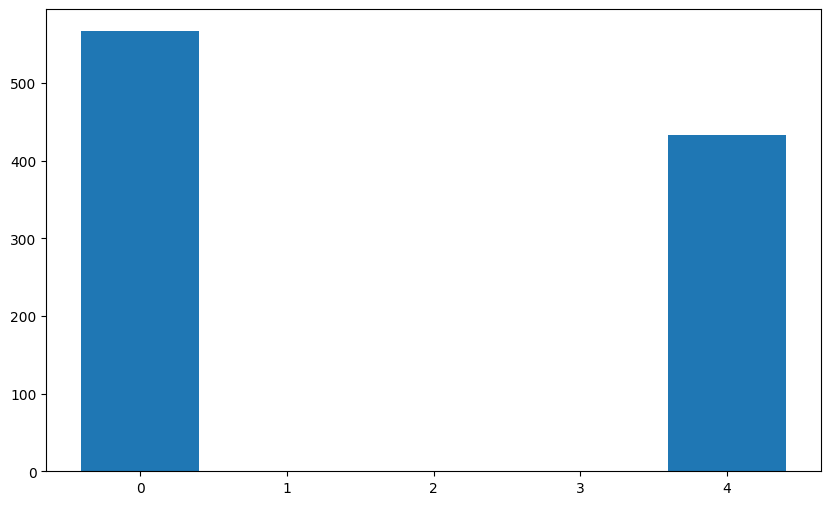

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
# from qiskit import *
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import datetime

# === code mode config ===
code_mode = 'annealing'  # [annealing, energy_gap, both, plot, test ...]
# !!!~~~ Recommand using 'fake' to test the correctness before using 'quantum' ~~~!!!
run_mode = 'fake'  # [classical, fake, quantum], fake: the fake provider by ibm (do not cost time resource, runs locally), whether to use the quantum computer of ibm
time_step_mode = 'standard'  # [flexible, standard], flexible denotes arranging time_step based on energy gap, while standard means linear arrangement.
circuit_draw = False  # [True, False], whether to draw the circuit

# === quantum computer config ===
optimization_level = 1  # [0, 1, 2, 3], with number increasing, the error lowers, while the depth increases.

# === circuit scale config ===
n=6
m=10*n  # Set m to be n^2
eta=0.1
kappa = 1  # The scaling of H_P (The objective hamiltonian) in the construction of H

rounds = 1  # How many eta's do we want to run in eta_candidate.
repeat = 1  # How many time do we want to repeat on the same eta.
eta_candidate = np.linspace(0.1, 0.3, 6)  # The candidates of eta

T=10
M=10*T  # Annealing step
dt_standard=T/M
shots_sampling = 1000
delta_min = 0.5
amplitude = 0.5  # The rate of gap increasing regarding the center
s_star = 0.5  # The step min_energy_gap occurs

# === clarification ===
s=[]
A=[]
y=[]

# === Folder to save the result ===
now  = datetime.datetime.now()
folder_name = now.strftime(f"RST_%m-%d_%H%M_{run_mode}")
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

#region === finetune time gap based on energy gap ===
dt_array = []
# def get_gap(s):
#     return np.sqrt(delta_min**2 + amplitude * (s - s_star)**2)
# s_grid = np.linspace(0, 1, M)
# # print(get_gap(s_grid))
# # weights = 1.0 / (get_gap(s_grid)**2)
# weights = get_gap(s_grid)**2
# dt_array = (weights / np.sum(weights)) * T
# # print(s_grid)
# # print(weights)
# if code_mode == 'plot' or code_mode == 'annealing':
#     x = np.linspace(0, M-1, M)
#     plt.plot(x, dt_array, label=f'time weight')
#     plt.legend()
#     plt.title("time weight")
#     plt.xlabel("step")
#     plt.ylabel("dt array")
#     if not os.path.exists(folder_name):
#         os.makedirs(folder_name)
#     plt.savefig(f"{folder_name}/dt_weight.png", dpi=300, bbox_inches='tight')
#endregion

# === Informations about quantum execution ===
# region
def print_job_stats(job, isa_circuit, backend):
    depth = isa_circuit.depth()
    gate_counts = isa_circuit.count_ops()

    result = job.result()
    metrics = job.metrics()
    running_time = metrics.get('running_time') 
    execution_time = metrics.get('execution_time')  # Execution time on cloud

    # avg_error = backend.target.avg_gate_error('cx') 
    
    print(f"Job ID: {job.job_id()}")
    print(f"Circuit Depth: {depth}")
    print(f"Gate number: {gate_counts}")
    print(f"Running time of quantum computer: {running_time}s")
    # print(f"Average error of CNOT gate: {avg_error:.4e}")

    record = {
        "job_id": job.job_id(),
        "backend": backend.name,
        "depth": depth,
        "running_time": running_time,
        "execution_time": execution_time
    }
    df = pd.DataFrame([record])
    df.to_json(f"{folder_name}/job_stats.json", orient="records", indent=4)
# endregion

#region === Initialization of matrix A and error vector e ===
def init():
    print("Qubit number (n):", n)
    global s, A, y
    s = []
    A = []
    y = []
    for i in range(n):
        s.append(random.randint(0,1))
    for i in range(m):
        A.append([])
        for j in range(n):
            A[i].append(random.randint(0,1))

        # A[i][random.randint(0,n-1)]=1
        # A[i][random.randint(0,n-1)]=1
        
        b=0
        for j in range(n):
            b^=A[i][j]*s[j]
        e=1 if random.random()<eta else 0
        y.append(b^e)
    print("Correct answer (s):", s)
#endregion

#region === Run the annealing algorithm to get the ground state ===
def run(repeat_idx):
    t=0
    global A, s, y

    # === Circuit Construction ===
    # region
    circ = QuantumCircuit(n+1,n)
    for i in range(n):
        circ.h(i)

    current_time = 0.0
    for i in range(M):
        if time_step_mode == 'standard':
            dt = dt_standard
            t=(i+0.5)*dt
            alpha=(1-t/T)
            beta=t/T

        if time_step_mode == 'flexible':
            dt = dt_array[i]
            t_mid = current_time + 0.5 * dt
            current_time += dt
            progress = t_mid / T
            alpha = 1.0 - progress
            beta = progress
            # print(t_mid)

        angle=2.0*beta*dt_standard

        for k in range(m):
            for j in range(n):
                if A[k][j]==1:
                    circ.cx(j,n)
            if y[k]==1:
                circ.x(n)

            circ.rz(angle,n)

            if y[k]==1:
                circ.x(n)
            for j in range(n-1,-1,-1):
                if A[k][j]==1:
                    circ.cx(j,n)

        for j in range(n):
            circ.rx(2.0*alpha*dt_standard,j)

    circ.measure(range(n),range(n))
    print("registers of circ:", circ.cregs)
    #endregion

    # === Draw the circuit (Optional) ===
    if circuit_draw == True:
        circ.draw('mpl', filename=f'{folder_name}/circuit_mpl.png')

    # === Run the Quantum Algorithm ===
    if run_mode == 'classical':
        simulator=AerSimulator()
        compiled_circuit=transpile(circ,simulator)
        job=simulator.run(compiled_circuit, shots=shots_sampling)
        result=job.result()
        counts = result.get_counts(circ)
    elif run_mode == 'quantum' or run_mode == "fake":
        if run_mode == 'fake':
            backend = FakeFez()
        if run_mode == 'quantum':
            backend = service.least_busy(simulator=False, operational=True)
        # transpile and run transpile
        pm = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend)
        isa_circuit = pm.run(circ)
        # run job
        sampler = Sampler(mode=backend)
        job = sampler.run([isa_circuit], shots=shots_sampling)
        result = job.result()
        
        # 5. 获取计数 (V2 Sampler 返回的是 PubResult)
        # 注意：V2 返回的是位串分布，通常需要处理一下来匹配 get_counts 的格式
        pub_result = result[0]
        counts = pub_result.data.c.get_counts() # 假设你的测量标号是默认的 'meas'
    else: 
        raise ValueError("run_mode can only be \'classical\' or \'quantum\'")
    
    # === Save the annealing result ===
    categories = []
    values = []
    instances = []

    for (a,b) in counts.items():
        s=[1 if x=='1' else 0 for x in a[::-1]]
        E=0
        for i in range(m):
            sum=y[i]
            for j in range(n):
                sum^=A[i][j]*s[j]
            E+=sum
        # print(s,E)
        # if E==0:
            # print(s)
        categories.append(E)
        values.append(b)
        instances.append(s)
    
    # === Merging all the data, classified by energy ===
    merged_data = {}
    instances_data = {}
    for category, value, instance in zip(categories, values, instances):
        if category in merged_data:
            merged_data[category] += value
        else:
            merged_data[category] = value
            instances_data[category] = instance

    min_energy = min(instances_data.items(), key=lambda item: item[0])
    print(min_energy)
    print('Merged data: ', merged_data)

    plt.figure(figsize=(10, 6))
    plt.bar(merged_data.keys(), merged_data.values())
    plt.savefig(f"{folder_name}/eta={eta}_{repeat_idx}.png", dpi=300, bbox_inches='tight')
    # plt.show()

    # === Print and save the job states ===
    print_job_stats(job, isa_circuit, backend)
#endregion

for i in range(rounds):
    # eta = 0.05*(i+1)
    eta = eta_candidate[i]
    for j in range(repeat):
        init()
        run(repeat_idx=j)